# Toy Model 1: Visualization Code

In [9]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.stats import beta
from scipy.stats import cumfreq, beta
%matplotlib inline
#plt.style.use('notebook.mplstyle')

## Setup
### Life, actions, and payoffs
- In essence, the Tinder platform represents to an agent a sequence of suggested partners
- The agent faces an infinite horizon, with time indexed as $t=1,2,...$ and a 'death rate' $(1-\delta)$
    - An agent can 'die' either because Tinder runs out of suggestions for her, or becuase she decides to quit
- Each suggested partner can be viewed as a Bernoulli-type lottery with some corresponding attractiveness payoff and a fixed probability of ‘being right-swiped’
    - $\left[\,\theta_t,0\;;\;\rho,(1-\rho)\,\right]$
- For each suggestion, the agent decides whether to 'participate in the lottery'
    - $a_t=\begin{cases}1 & \text{swipe right}\\0 & \text{swipe left}\end{cases}$
- Given the agent participates, expected utility from matching is $U(\theta_t ) = \rho u(\theta_t)$, where $u(\cdot)$ is a v-NM utility function satisfying $u(0)=0$
    - This is important because, if $u(0)<0$, then matching with some (ugly) people is worse than just skipping them


### Costly swiping
- Left swiping is costly as the agent can die the next round, so why not swipe right on everyone?
- Tinder makes right-swiping costly by placing a cap on the total number of right swipes for each user. We refer to this as the agent’s budget $b_t$   
- The budget is evolves dynamically according to the law of motion:
    - $b_{t+1}= b_t  - a_t$
- The starting budget, $b_0$, is determined exogenously 

## The Agent's Problem 
$$
 \begin{aligned} \max_{\{a_t\}^\infty_{t=1}} \quad & \mathbb{E}_{\theta_t}\left[\sum^\infty_{t=1} \delta^{t-1} a_t\rho u(\theta_t) \right]\\\\ \textrm{s.t.} \quad &b_{t+1}  = b_t -a_t \\ &b_t\in \{b_0\,\,...,0\} \\ & a_t\in \{0,1\} \\ & \theta_t \sim \text{Beta}(\alpha, \beta)\end{aligned}
$$

## Exogenous model parameters

In [10]:
# Setting exogenous parameters
def reset_exog_params():
    global b_0, δ, u , α, β
    b_0 = 40
    δ = 0.9
    u = lambda x : x
    α,β = (1,1)

## Solving the model

- Define the set of stationary Markov policies $\Pi$ such that $\pi: \Theta \times \mathcal{B} \rightarrow\mathcal{A}$
- The value function for this problem is given by:

$$
V(\theta, b)= \max_{\pi}\;\mathbb{E}_{\pi}\left[\sum^\infty_{t=1} \delta^{t-1} \pi(\theta_t, b_t) \left[\rho u(\theta_t)\right]\,|\, \theta_0,b_0=\theta,b\right] 
$$

- Corresponding Bellman equation of the agent's problem (drop time subscript to highlight stationarity):

$$
 V(\theta, b)=\max \, \left \{\,\rho u(\theta) +\delta \,\mathbb{E}_{\theta'}\left[V(\theta, b-1)\right] \,,\;\delta \,\mathbb{E}_{\theta'}\left[\,V(\theta',b )\,\right]\,\right\}
$$

- Optimal policy can be parametarized by a cutoff attractiveness due to the piecewise nature of the value function:

$$
 \pi^*(\theta,b)=\begin{cases}1,\quad \theta\geq\theta^*_b \\ 0, \quad\theta<\theta^*_b  \end{cases}
$$
    
- Cutoff attractiveness  $\theta^*_b$ is naturally defined such that the current period utility of a right-swipe is equal to the discounted loss in expected value from a unit decrease in budget :

$$
 \rho u(\theta^*_b) = \delta \,\mathbb{E}_{\theta'}\left[\,V(\theta',b)-V(\theta',b-1)\,\right]
$$

- We can see how this creates the piecewise nature of value function (graph in notebook) :
    - Note $\mathbb{E}_{\theta'}\left[V(\theta', b)\right]$ is a constant for all $b\in\mathcal{B}$

$$
 V(\theta, b)=\begin{cases}\rho u(\theta) +\delta \,\mathbb{E}_{\theta'}\left[V(\theta', b-1)\right],\quad \theta>\theta^*_b \\\\ \delta \,\mathbb{E}_{\theta'}\left[V(\theta', b)\right],\quad \theta\leq\theta^*_b\end{cases}
$$

- The explicit threshold at different budget levels are determined by the two equations below
    - The first equation defines an implicit recursive relation  $\theta^*_b = \varphi(\theta^*_{b-1})$ , and is derived by evaluating $(2)$ and $(3)$
    - The second one can be solved for $\theta^*_1$ to provide an initial condition, and is derived by combining and evaluating $(2)$, $(3)$ and the initial condition $V(\theta,0)=0$

$$
 u(\theta^*_b) = \delta u(\theta^*_b) F(\theta^*_b) \,+\, \delta u(\theta^*_{b-1})\left[1-  F(\theta^*_{b-1})\right]\,+\,\delta\int^{\theta^*_{b-1}}_{\theta^*_b} u(\theta')dF(\theta')
$$

$$
u(\theta^*_1) =\delta u(\theta^*_1)F(\theta^*_1) + \delta \int^1_{\theta^*_1}u(\theta')dF(\theta')
$$

In [11]:
# Initial condition equation
def initial_condition(x):
    return (u(x) 
            - δ * u(x) * beta.cdf(x,α,β) 
            - δ * integrate.quad(lambda t: u(t) * beta.pdf(t,α,β), x, 1)[0])

# Recurrence relation 
def phi(x):
    return (u(x) 
            - δ * u(x) * beta.cdf(x,α,β) 
            - δ * u(θ_prev)*(1-beta.cdf(θ_prev,α,β)) 
            - δ * integrate.quad(lambda t : u(t) * beta.pdf(t,α,β), x, θ_prev)[0])

## Computing initial condition $\theta^*_1$

In [12]:
# Resetting exogenous parameters
reset_exog_params()

θ_1 = optimize.root_scalar(initial_condition, bracket=[0,1], method='brentq')
print(θ_1.root, θ_1.converged)

0.6267890062732583 True


## Computing $\left\{\theta^*_B\right\}^{B_0}_{B=1}$

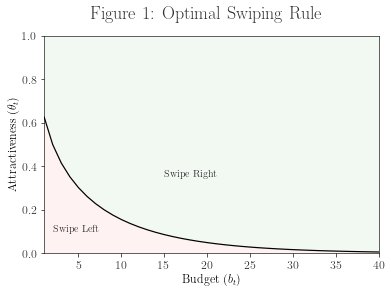

In [13]:
# Resetting exogenous parameters
reset_exog_params()

# Computing thetas
b_vals = range(1,b_0+1)
θ_vals = [optimize.root_scalar(initial_condition, bracket=[0,1], method='brentq').root]
for i in range(b_0-1):
    θ_prev = θ_vals[i]
    θ_vals.append(optimize.root_scalar(phi, bracket=[0,1], method='brentq').root)

# Plotting swiping rule    
fig, ax = plt.subplots()
ax.set_xlim(1,b_0)
ax.set_ylim(0,1)
ax.plot(b_vals, θ_vals, color='k')
ax.fill_between(b_vals, 0, θ_vals, color='red', alpha=0.05)
ax.fill_between(b_vals, θ_vals, 1, color='green', alpha=0.05)
ax.text(2, 0.1, 'Swipe Left')
ax.text(15, 0.35, 'Swipe Right')
ax.set(xlabel=r'Budget ($b_t$)', ylabel=r'Attractiveness ($\theta_t$)')
fig.suptitle('Figure 1: Optimal Swiping Rule')
plt.show()

## Comparative statics on discount factor $\delta$

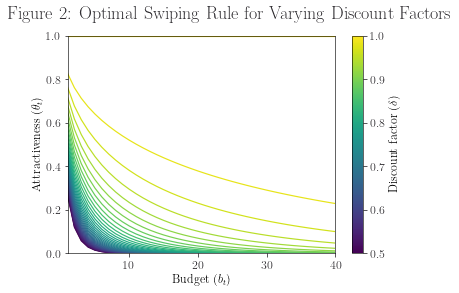

In [14]:
# Resetting exogenous parameters
reset_exog_params()

δ_vals = np.logspace(-1, 0, 40, base=2)
b_vals = range(1,b_0+1)
swiping_rules = []

for d in δ_vals:
    δ = d
    θ_vals = [optimize.root_scalar(initial_condition, bracket=[0,1], method='brentq').root]
    for i in range(b_0-1):
        θ_prev = θ_vals[i]
        θ_vals.append(optimize.root_scalar(phi, bracket=[0,1], method='brentq').root)
    swiping_rules.append(θ_vals) 

# Plotting swiping rules
fig, ax = plt.subplots()
ax.set_xlim(1,b_0)
ax.set_ylim(0,1)
line_segments = LineCollection([np.column_stack([b_vals, θ_vals]) 
                                for θ_vals in swiping_rules])
line_segments.set_array(np.array(δ_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Discount factor ($\delta$)')
fig.suptitle('Figure 2: Optimal Swiping Rule for Varying Discount Factors')    
ax.set(xlabel=r'Budget ($b_t$)', ylabel=r'Attractiveness ($\theta_t$)')
plt.show()    

## Comparative statics on absolute risk aversion
Consider an agent with exponential utility and a coefficient of absolute risk aversion $r$

$$
 u(\theta) \,=\, \begin{cases} \left(1-e^{-r\theta}\right)/r & r\neq0 \\ \theta & r=0\end{cases}
$$

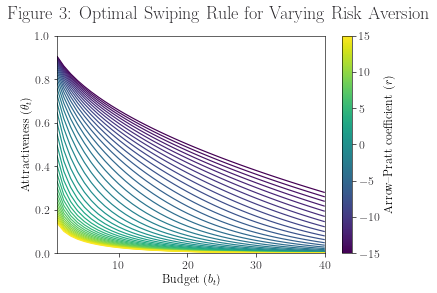

In [15]:
# Resetting exogenous parameters
reset_exog_params()

# Exponential utility function
def u(x):
    if r !=0: 
        return (1 - np.exp(-r*x))/r
    return x 

cara_vals = np.linspace(-15,15,40)
b_vals = range(1,b_0+1)
swiping_rules = []

for cara in cara_vals:
    r = cara
    θ_vals = [optimize.root_scalar(initial_condition, bracket=[0,1], method='brentq').root]
    for i in range(b_0-1):
        θ_prev = θ_vals[i]
        θ_vals.append(optimize.root_scalar(phi, bracket=[0,1], method='brentq').root)
    swiping_rules.append(θ_vals) 
        
# Plotting swiping rules
fig, ax = plt.subplots()
ax.set_xlim(1,b_0)
ax.set_ylim(0,1)
line_segments = LineCollection([np.column_stack([b_vals, θ_vals]) 
                                for θ_vals in swiping_rules])
line_segments.set_array(np.array(cara_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Arrow–Pratt coefficient ($r$)')
fig.suptitle('Figure 3: Optimal Swiping Rule for Varying Risk Aversion')    
ax.set(xlabel=r'Budget ($b_t$)', ylabel=r'Attractiveness ($\theta_t$)')
plt.show()

## Comparative statics on the attractiveness distribution 
Given $\theta_t \sim \text{Beta}(\alpha, \beta)$, the variance of suggested partner attractiveness is:
$$
 \mathbb{V}[\theta_t]=\frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}
$$ 
 

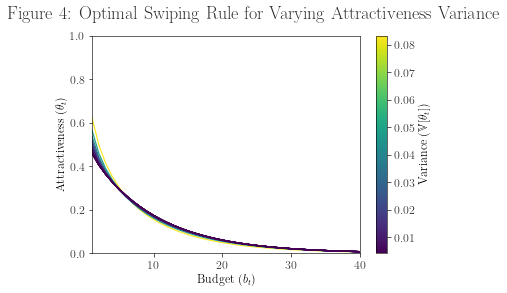

In [16]:
# Resetting exogenous parameters
reset_exog_params()

shape_vals = [(i,i) for i in range(1,30)]
var_vals = [(a*b)/((a+b+1)*(a+b)**2) 
            for a,b in shape_vals]

b_vals = range(1,b_0+1)
swiping_rules = []

for s in shape_vals:
    α,β = s
    θ_vals = [optimize.root_scalar(initial_condition, bracket=[0,1], method='brentq').root]
    for i in range(b_0-1):
        θ_prev = θ_vals[i]
        θ_vals.append(optimize.root_scalar(phi, bracket=[0,1], method='brentq').root)
    swiping_rules.append(θ_vals) 

# Plotting swiping rules
fig, ax = plt.subplots()
ax.set_xlim(1,b_0)
ax.set_ylim(0,1)
line_segments = LineCollection([np.column_stack([b_vals, θ_vals]) 
                                for θ_vals in swiping_rules])
line_segments.set_array(np.array(var_vals))
ax.add_collection(line_segments)
axcb = fig.colorbar(line_segments)
axcb.set_label(r'Variance ($\mathbb{V}[\theta_t]$)')
fig.suptitle('Figure 4: Optimal Swiping Rule for Varying Attractiveness Variance')    
ax.set(xlabel=r'Budget ($b_t$)', ylabel=r'Attractiveness ($\theta_t$)')
plt.show()    